In [122]:
import matplotlib.pyplot as plt 
from matplotlib import dates, colors, ticker
import numpy as np 
import pandas as pd 
from astropy import units as u 
from astropy.io import fits
from pathlib import Path
from astropy.table import QTable, vstack
from astropy.time import Time
from sunpy.time import parse_time
from sunpy.net import Fido, attrs as a
from sunpy import timeseries as ts
import pandas as pd
from scipy.signal import savgol_filter
import seaborn as sns
#sns.set_context("paper", font_scale=1.5, rc={"font.family" : "Helvetica"})
sns.set_context("talk", font_scale=1.5, rc={"font.family" : "Helvetica"})

In [2]:
tstart = Time("2021-08-28 05:02")
tend = Time("2021-08-28 05:10")

In [3]:
# res = Fido.search(a.Time(tstart, tend), a.Instrument("XRS"), a.goes.SatelliteNumber(16))
# Fido.fetch(res, path="./")

In [4]:
goes_ts = ts.TimeSeries('sci_xrsf-l2-flx1s_g16_d20210828_v2-1-0.nc').truncate(tstart.datetime, tend.datetime)
gl = goes_ts.to_dataframe()["xrsb"]#.resample("60s").mean()
gs = goes_ts.to_dataframe()["xrsa"]#.resample("60s").mean()

In [5]:
%matplotlib inline

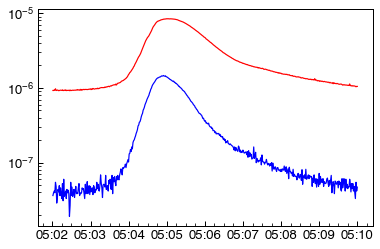

In [6]:
fig, ax = plt.subplots()
ax.plot(gl, color='r')
ax.plot(gs, color='b')
plt.yscale("log")
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

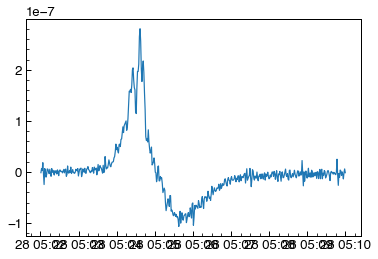

In [7]:
plt.plot(gl.index, np.gradient(gl))

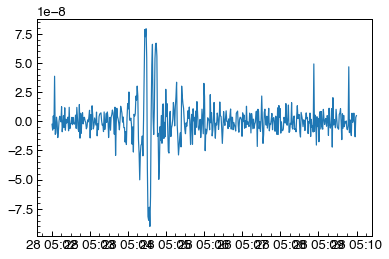

In [8]:
plt.plot(gl - savgol_filter(gl, 21, 3))

## Lets read the STIX data

### STIX files

In [9]:
# stix_filespec = "solo_L1A_stix-sci-spectrogram-2111010001_20211101T003900-20211101T032545_055094_V01.fits"
# fits_path_bk = "solo_L1A_stix-sci-xray-l1-2111010038_20211101T140006-20211101T153606_056537_V01.fits"
# stix_filel1 = "solo_L1A_stix-sci-xray-l1-2111010024_20211101T010049-20211101T023158_017507_V01.fits"

# fits_bg1 = "solo_L1A_stix-sci-xray-l1-2110310071_20211031T111705-20211031T125305_056536_V01.fits"
# fits_bg2 = "solo_L1A_stix-sci-xray-l1-2111010016_20211101T100013-20211101T114013_017219_V01.fits"

In [10]:
ls *.fits

solo_L1A_stix-sci-spectrogram-2108290171_20210828T045524-20210828T051525_036655_V01.fits
solo_L1A_stix-sci-xray-l1-2108200018_20210820T012017-20210820T025617_029671_V01.fits
solo_L1A_stix-sci-xray-l1-2108250234_20210825T235512-20210826T013512_025858_V01.fits


In [11]:
def read_stix_fitsl1(filename, tstart=None, tend=None, light_time_correction=0*u.s):
    file = Path(filename)
    header = fits.getheader(file)
    control = QTable.read(file, hdu=1)
    data = QTable.read(file, hdu=2)
    data['time'] = Time(header['date_obs']) + data['time']
    energies = QTable.read(file, hdu=3)
    data["time"] = data["time"] + light_time_correction
    
    if tstart is not None:
        truncated_inds = (data["time"]>=tstart)*(data["time"]<=tend)

        data = data[truncated_inds]
    
    dE = (energies['e_high'] - energies['e_low'])
    dE[[0, -1]] = 1 * u.keV
    e_norm = dE
    t_norm = data["timedel"]

    

    
    if "spec" in filename:
        e_norm = e_norm.reshape(1, -1)
        t_norm = t_norm.reshape(-1, 1)        
    else:
        e_norm = e_norm.reshape(1, 1, 1, -1)
        t_norm = t_norm.reshape(-1, 1, 1, 1)

    counts = data["counts"]
    counts_var = data['counts_err']**2  
    

    count_rate = counts/e_norm/t_norm
    stix_struct = {"counts": counts, "counts_var": counts_var, "count_rate": count_rate, 
                   "e_norm": e_norm, "t_norm": t_norm, "times": data["time"], "e_low": energies["e_low"], 
                   "e_high": energies["e_high"]}
    
    return stix_struct

In [77]:
stix_file = "solo_L1A_stix-sci-spectrogram-2108290171_20210828T045524-20210828T051525_036655_V01.fits"
stix_bgfile_1 = "solo_L1A_stix-sci-xray-l1-2108200018_20210820T012017-20210820T025617_029671_V01.fits"
stix_bgfile_2 = "solo_L1A_stix-sci-xray-l1-2108250234_20210825T235512-20210826T013512_025858_V01.fits"

In [78]:
tstart = Time("2021-08-28 05:02")
tend = Time("2021-08-28 05:07")

In [79]:
light_travel_time = 194*u.s
#light_travel_time = 192.2*u.s

In [80]:
stix_data = read_stix_fitsl1(stix_file, tstart=tstart, tend=tend, light_time_correction=light_travel_time)
stix_data_bg = read_stix_fitsl1(stix_bgfile_1)
stix_data_bg2 = read_stix_fitsl1(stix_bgfile_1)

In [81]:
stix_data["e_low"][10:15]

<Quantity [13., 14., 15., 16., 18.] keV>

In [82]:
#gbm_struct["e_min"][10:15]

In [83]:
# fig, ax = plt.subplots()

# ax.plot(gbm_struct["time_array"], np.sum(gbm_struct["count_rate"][:, 10:15], axis=1), 
#          drawstyle="steps-mid")
# ax2 = ax.twinx()
# ax2.plot(stix_data["times"].datetime, np.sum(stix_data["count_rate"][:, 10:15], axis=1), 
#          drawstyle="steps-mid", color='r')

# ax.set_xlim("2021-08-28 05:03", "2021-08-28 05:06")

In [84]:
stix_data["count_rate"] = stix_data["count_rate"] - np.sum(stix_data_bg2["count_rate"], axis=(1,2))
stix_data["count_rate"][13:15, :] = np.nan ## getting rid of weird thing

In [85]:
np.where((stix_data["e_low"]>=20*u.keV)&(stix_data["e_low"]<=28*u.keV))

(array([15, 16, 17, 18]),)

In [86]:
%matplotlib notebook

<IPython.core.display.Javascript object>


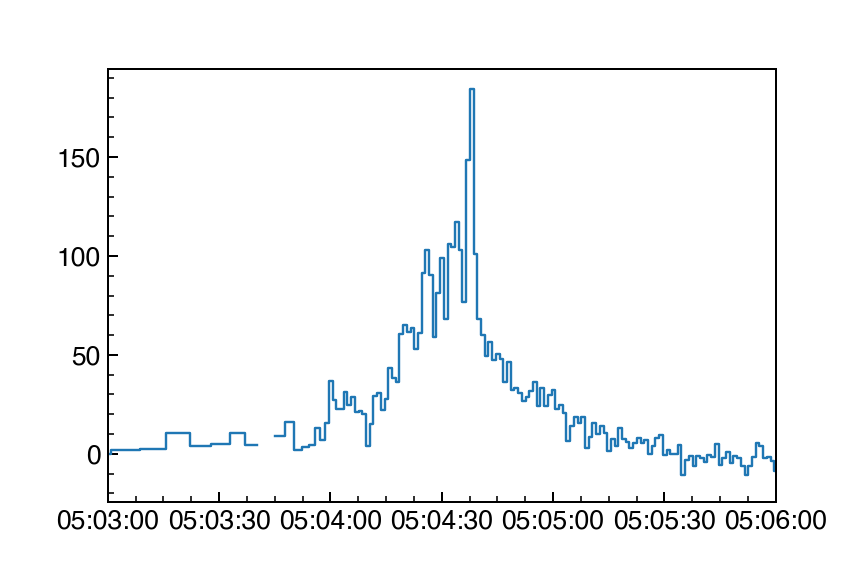

(18867.210416666665, 18867.2125)

In [87]:
fig, ax = plt.subplots()
plt.plot(stix_data["times"].datetime, np.sum(stix_data["count_rate"][:, 13:20], axis=1), drawstyle="steps-mid")
# plt.plot(stix_data["times"].datetime, np.sum(stix_data["count_rate"][:, 7:14], axis=1))
# plt.axvspan(stix_data["times"].datetime[2], stix_data["times"].datetime[10], alpha=0.1)
# # plt.yscale("log")
# #plt.ylim(0, 200)
# ax2 = ax.twinx()
# ax2.plot(gl.index, np.gradient(gl), color='r', drawstyle="steps-mid")
# ax2.set_xlim(stix_data["times"].datetime[0], stix_data["times"].datetime[-1])
ax.set_xlim("2021-08-28 05:03", "2021-08-28 05:06")

In [88]:
plt.plot(np.sum(stix_data["count_rate"][:, 13:20], axis=1))
plt.axvline(12, color='r')
plt.axvline(14, color='r')

In [89]:
np.sum(stix_data["count_rate"][:, 13:20], axis=1)[13:15]

<Quantity [nan, nan] ct / (keV s)>

In [90]:
bg_count_rate = np.mean(stix_data["count_rate"][0:10, :], axis=0)
bg_count_rate = bg_count_rate.reshape(1, -1)

In [91]:
stix_data["count_rate"][13:15, :] = np.nan

In [92]:
stix_data["count_rate_sub"] = stix_data["count_rate"] - bg_count_rate

In [93]:
en_inds = np.where((stix_data["e_low"]>=10*u.keV)&(stix_data["e_low"]<=100*u.keV))[0]

In [94]:
def plot_struct(stix_data, spec=False, cmap="viridis"):
    cmap=plt.cm.Spectral_r.copy()
    cmap.set_bad(cmap(0))
    if not spec:
        stix_spec = np.mean(stix_data["count_rate"], axis=(1,2))
    else:
        stix_spec = stix_data["count_rate"]
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.pcolormesh(stix_data["times"].datetime, stix_data["e_low"].value[en_inds], 
                  stix_spec[:, en_inds].T, #norm=colors.PowerNorm(gamma=0.3, vmin=0.1),
                  cmap=cmap, norm=colors.LogNorm(vmin=1.5))
    ax.set_yscale("log")
    ax.set_ylim(10, 100)
    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
    ax.set_xlabel("Time {:s} UT".format(stix_data["times"][0].strftime("%Y-%m-%d")))
    cbar = fig.colorbar(im)
    cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    

<IPython.core.display.Javascript object>


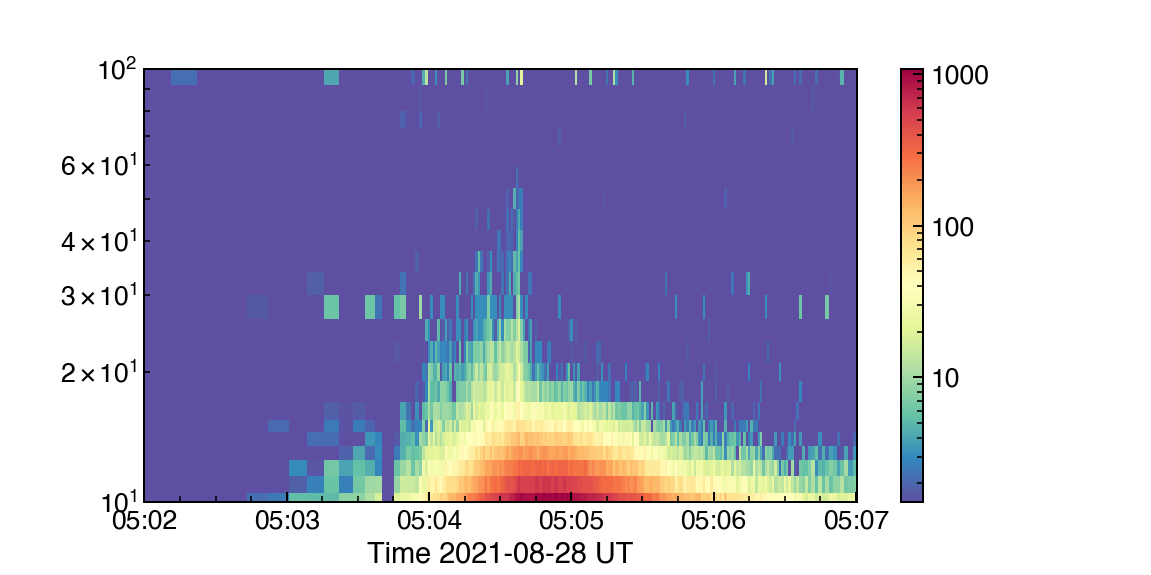

In [95]:
plot_struct(stix_data, spec=True)

## FERMI data

In [96]:
ls *.pha

glg_cspec_n1_210828_v00.pha* glg_cspec_n4_210828_v00.pha*
glg_cspec_n3_210828_v00.pha* glg_cspec_n5_210828_v00.pha*


In [97]:
detectors = [1, 3, 4, 5]
detector = 5
fermi_file = "glg_cspec_n{:d}_210828_v00.pha".format(detector)


In [98]:
def read_gbm(fermi_file, tstart, tend):
    hdu_fermi = fits.open(fermi_file)

    data_file = fits.open(fermi_file)
    energies = data_file[1].data
    count_data = data_file[2].data


    met_ref_time = parse_time('2001-01-01 00:00')  # Mission elapsed time
    gbm_times = met_ref_time + count_data['time']*u.s
    gbm_times.precision = 9
    gbm_times = gbm_times.isot.astype('datetime64')

    gbm_counts = count_data["counts"]
    exptime = count_data["exposure"]
    quality = count_data["quality"] # 1 is bad

    truncated_inds = (gbm_times>=tstart)*(gbm_times<=tend)
    gbm_count_array = gbm_counts[truncated_inds, :]
    gbm_time_array = gbm_times[truncated_inds]
    gbm_exptime = exptime[truncated_inds]
    gbm_quality = quality[truncated_inds]

    dE_gbm = (energies['e_max'] - energies['e_min'])
    e_norm_gbm = dE_gbm.reshape(1, -1)
    t_norm_gbm = gbm_exptime.reshape(-1, 1)

    gbm_count_rate = gbm_count_array/e_norm_gbm/t_norm_gbm
    
    gbm_struct = {"counts": gbm_count_array, "time_array":gbm_time_array, "count_rate":gbm_count_rate, 
                  "e_min": energies["e_min"], "e_max": energies["e_max"], "quality":gbm_quality}
    return gbm_struct

In [99]:
gbm_struct = read_gbm(fermi_file, tstart, tend)

In [100]:
e_inds_gbm = (gbm_struct["e_min"]>=10)&(gbm_struct["e_min"]<=100)


fix bad data with the subsequent data value

In [101]:
bad_flags = np.where(gbm_struct["quality"]==1)[0]

In [102]:
gbm_struct["count_rate"][bad_flags, :] = gbm_struct["count_rate"][bad_flags+1, :]

<IPython.core.display.Javascript object>


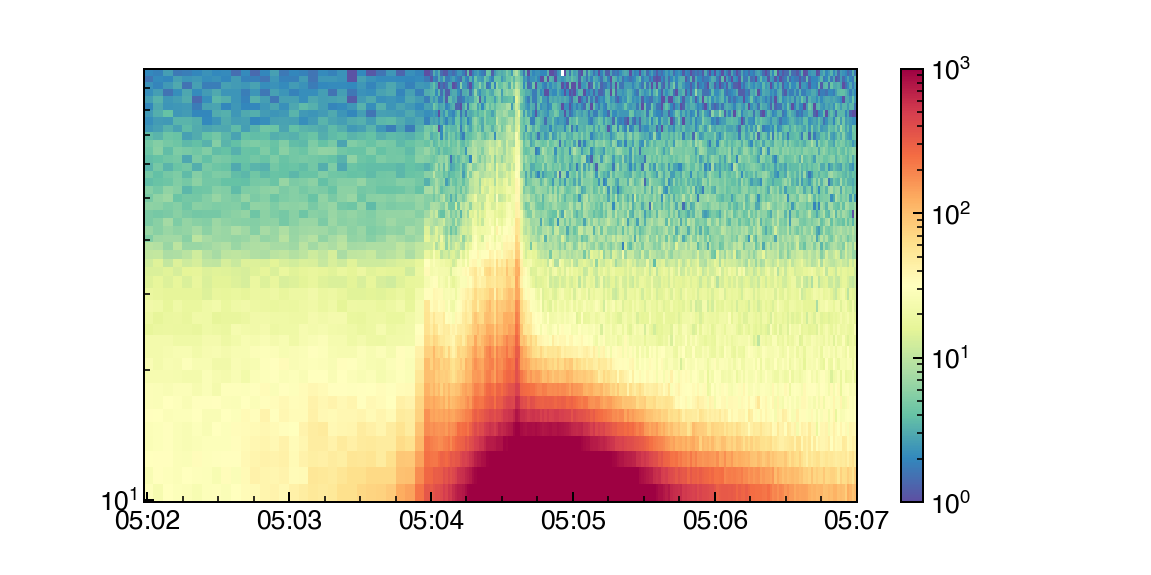

In [103]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
               gbm_struct["count_rate"][:, e_inds_gbm].T, 
               norm=colors.LogNorm(vmax=1000, vmin=1),cmap="Spectral_r")

plt.yscale("log")
plt.colorbar()
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

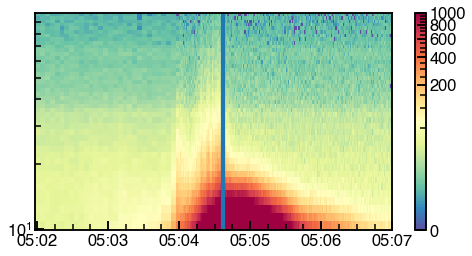

In [130]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
               gbm_struct["count_rate"][:, e_inds_gbm].T, 
               norm=colors.PowerNorm(gamma=1./4, vmax=1000, vmin=1),cmap="Spectral_r")

plt.yscale("log")
plt.colorbar()
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
plt.axvline("2021-08-28 05:04:36")
plt.axvline("2021-08-28 05:04:38")

In [107]:
det_area = np.pi*((12.7/2)*u.cm)**2

In [108]:
det_area

<Quantity 126.67686977 cm2>

In [109]:
np.where((gbm_struct["e_min"]>=18)&(gbm_struct["e_min"]<=40))

(array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),)

<IPython.core.display.Javascript object>


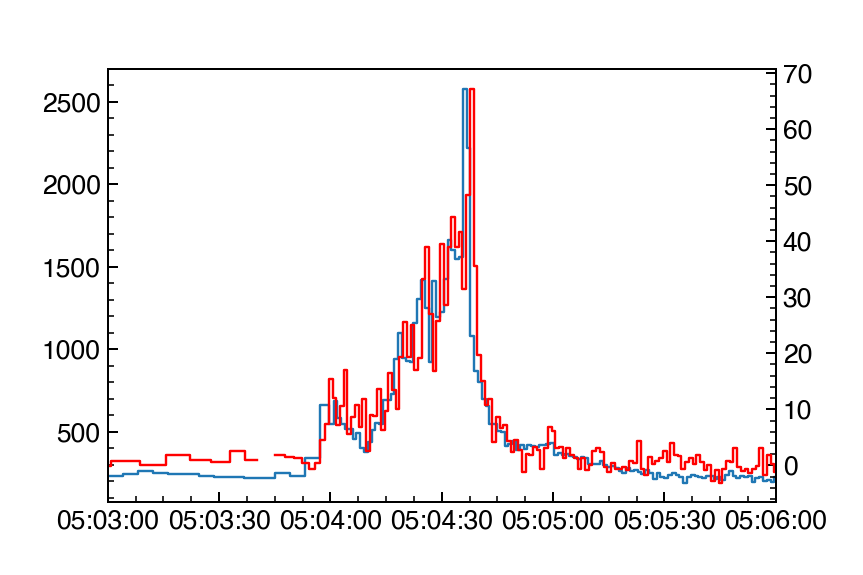

(18867.210416666665, 18867.2125)

In [110]:
fig, ax = plt.subplots()

ax.plot(gbm_struct["time_array"], np.sum(gbm_struct["count_rate"][:, 15:27], axis=1), 
         drawstyle="steps-mid")
ax2 = ax.twinx()
ax2.plot(stix_data["times"].datetime, np.sum(stix_data["count_rate"][:, 15:18], axis=1), 
         drawstyle="steps-mid", color='r')

ax.set_xlim("2021-08-28 05:03", "2021-08-28 05:06")

In [111]:
%matplotlib inline

# Plot together!

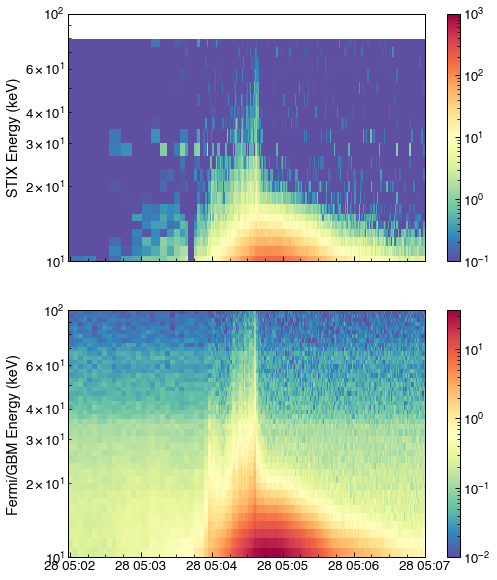

In [112]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8, 10))

cmap_stix = plt.cm.Spectral_r.copy()
cmap_stix.set_bad(cmap_stix(0))

stix_en_inds = np.where((stix_data["e_low"].value>=10)&(stix_data["e_high"].value<100))[0]
im_stix = ax1.pcolormesh(stix_data["times"].datetime, stix_data["e_low"].value[stix_en_inds], 
                         stix_data["count_rate"][:, stix_en_inds].T/6, 
               norm=colors.LogNorm(vmin=0.1, vmax=1e3), cmap=cmap_stix)
ax1.set_yscale("log")
ax1.set_ylim(10, 100)
ax1.set_ylabel("STIX Energy (keV)")

ax2.sharey(ax1)
im_fermi = ax2.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
               gbm_struct["count_rate"][:, e_inds_gbm].T/127, 
               norm=colors.LogNorm(vmin=0.01), cmap=cmap_stix)
ax2.set_yscale("log")
ax2.set_ylabel("Fermi/GBM Energy (keV)")

fig.colorbar(im_stix, ax=ax1)
fig.colorbar(im_fermi, ax=ax2)

In [113]:
gbm_struct["count_rate_bg"] = gbm_struct["count_rate"] - gbm_struct["count_rate"][0, :]

In [114]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8, 12))
# # GOES plot
# # ax1.plot(gl, color='r', label="1-8$\mathrm{\AA}$")
# # ax1.plot(gs, color='b', label="0.5-4$\mathrm{\AA}$")
# # ax1.set_yscale("log")
# # ax1.set_ylabel("Flux Wm$^{-2}$")
# # ax1.set_xlim(gl.index[0], gl.index[-1])

# # STIX plot
# cmap_stix = plt.cm.Spectral_r.copy()
# cmap_stix.set_bad(cmap_stix(0))
# stix_en_inds = np.where((stix_data_sub["e_low"].value>=10)&(stix_data_sub["e_high"].value<100))[0]
# im_stix = ax2.pcolormesh(stix_data_sub["times"].datetime, stix_data_sub["e_low"].value[stix_en_inds], 
#                np.sum(stix_data_sub["count_rate"], axis=(1,2))[:, stix_en_inds].T/6, 
#                norm=colors.PowerNorm(gamma=0.4, vmin=0.06, vmax=15), cmap=cmap_stix)
# ax2.set_yscale("log")
# ax2.set_ylim(10, 100)
# ax2.set_ylabel("STIX Energy (keV)")


# # GBM plot
# ax3.sharey(ax2)
# im_fermi = ax3.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
#                gbm_struct["count_rate"][:, e_inds_gbm].T, 
#                norm=colors.PowerNorm(gamma=0.4, vmin=5, vmax=1000), cmap=cmap_stix)
# ax3.set_yscale("log")
# ax3.set_ylabel("Fermi/GBM Energy (keV)")

# ax1.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
# ax2.set_yticks([10, 100])
# ax2.minorticks_off()
# ax3.set_yticks([10, 100])
# ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax3.yaxis.set_major_formatter(ticker.ScalarFormatter())


# axins_fermi = inset_axes(ax3,
#                    width="2%",  # width = 5% of parent_bbox width
#                    height="100%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(1.01, 0., 1, 1),
#                    bbox_transform=ax3.transAxes,
#                    borderpad=0,
#                    )

# axins_stix = inset_axes(ax2,
#                    width="2%",  # width = 5% of parent_bbox width
#                    height="100%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(1.01, 0., 1, 1),
#                    bbox_transform=ax2.transAxes,
#                    borderpad=0,
#                    )


# cbar_fermi = fig.colorbar(im_fermi, cax=axins_fermi, orientation='vertical')
# cbar_stix = fig.colorbar(im_stix, cax=axins_stix, orientation='vertical')

# cbar_stix.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# cbar_fermi.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


# ax3.set_xlabel("Time {:s} UT".format(gl.index[0].strftime("%Y-%m-%d")))
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.05)

# plt.savefig("overview_nov_pnorm.png")

In [128]:
sns.set_context("talk", font_scale=1., rc={"font.family" : "Helvetica"})

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_75569/2364442723.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


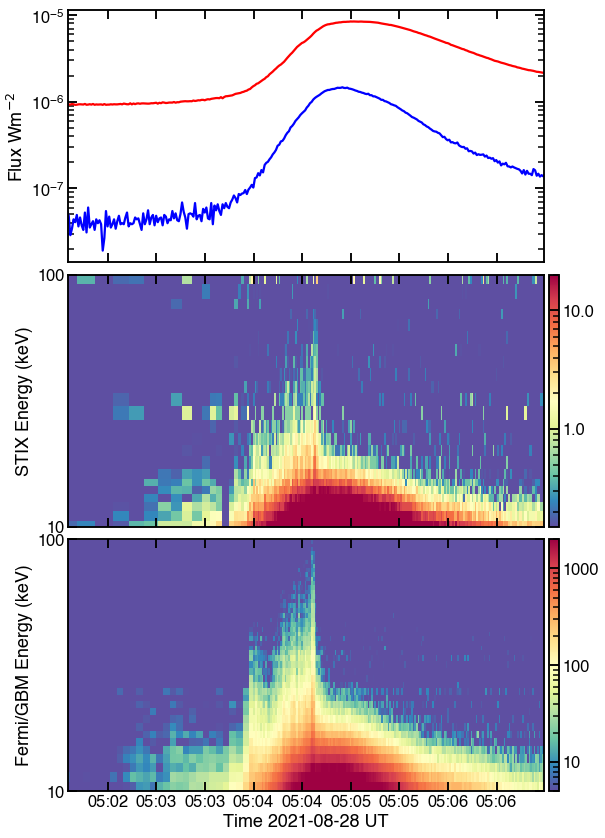

In [129]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8, 12))
# GOES plot
ax1.plot(gl, color='r', label="1-8$\mathrm{\AA}$")
ax1.plot(gs, color='b', label="0.5-4$\mathrm{\AA}$")
ax1.set_yscale("log")
ax1.set_ylabel("Flux Wm$^{-2}$")
ax1.set_xlim(stix_data["times"].datetime[0], stix_data["times"].datetime[-1])

# STIX plot
cmap_stix = plt.cm.Spectral_r.copy()
cmap_stix.set_bad(cmap_stix(0))
stix_en_inds = np.where((stix_data["e_low"].value>=10)&(stix_data["e_low"].value<=100))[0]
im_stix = ax2.pcolormesh(stix_data["times"].datetime, stix_data["e_low"].value[stix_en_inds], 
               stix_data["count_rate"][:, stix_en_inds].T/6, 
               norm=colors.LogNorm(vmin=0.15, vmax=20), cmap=cmap_stix)
ax2.set_yscale("log")
ax2.set_ylim(10, 100)
ax2.set_ylabel("STIX Energy (keV)")


# GBM plot
ax3.sharey(ax2)
im_fermi = ax3.pcolormesh(gbm_struct["time_array"], gbm_struct["e_min"][e_inds_gbm], 
               gbm_struct["count_rate_bg"][:, e_inds_gbm].T, 
               norm=colors.LogNorm(vmin=5, vmax=2000), cmap=cmap_stix)
ax3.set_yscale("log")
ax3.set_ylabel("Fermi/GBM Energy (keV)")

ax1.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax2.set_yticks([10, 100])
ax2.minorticks_off()
ax3.set_yticks([10, 100])
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax3.yaxis.set_major_formatter(ticker.ScalarFormatter())


axins_fermi = inset_axes(ax3,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )

axins_stix = inset_axes(ax2,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )

for a in (ax1, ax2, ax3):
    a.tick_params(which="both", top=True, right=True)

cbar_fermi = fig.colorbar(im_fermi, cax=axins_fermi, orientation='vertical')
cbar_stix = fig.colorbar(im_stix, cax=axins_stix, orientation='vertical')

cbar_stix.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

cbar_fermi.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


ax3.set_xlabel("Time {:s} UT".format(gl.index[0].strftime("%Y-%m-%d")))
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)


plt.savefig("overview_aug_spec.png")

## Try STIX spec data

## Plot the timeseries

In [117]:
ind_2028_gbm = (gbm_struct["e_min"]>=20)&(gbm_struct["e_max"]<=28)
test_2028 = pd.Series(np.sum(gbm_struct["count_rate"][:, ind_2028_gbm], axis=1), index=gbm_struct["time_array"])

for i in range(np.sum(ind_2028_gbm)):
    print(gbm_struct["e_min"][ind_2028_gbm][i], gbm_struct["e_max"][ind_2028_gbm][i])

20.70291 22.07131
22.07131 23.457895
23.457895 24.877317
24.877317 26.344217


In [118]:
ind_2028_stix = (stix_data["e_low"].value>=20)&(stix_data["e_high"].value<=28)
test_stix_2028 = pd.Series(np.sum(np.sum(stix_data["count_rate"], axis=(1, 2))[:, ind_2028_stix], axis=1), 
                           index=stix_data["times"].datetime)
for i in range(np.sum(ind_2028_stix)):
    print(stix_data["e_low"][ind_2028_stix][i], stix_data["e_high"][ind_2028_stix][i])

AxisError: axis 2 is out of bounds for array of dimension 2

In [ ]:
ind_2028_stix2 = (stix_data_spec["e_low"].value>=20)&(stix_data_spec["e_high"].value<=28)
test_stix_2028_spec = pd.Series(np.sum(stix_data_spec["count_rate"][:, ind_2028_stix2], axis=1), 
                           index=stix_data_spec["times"].datetime)
for i in range(np.sum(ind_2028_stix2)):
    print(stix_data_spec["e_low"][ind_2028_stix2][i], stix_data_spec["e_high"][ind_2028_stix2][i])

In [ ]:
gbm_test = test_2028.resample("4s").mean().interpolate()
stix_test = test_stix_2028.resample("4s").mean().interpolate()
stix_test_spec = test_stix_2028_spec.resample("4s").mean().interpolate()

In [ ]:
fig, ax = plt.subplots()
ax.plot((gbm_test)/127)
ax.plot(stix_test/6)
ax.plot(stix_test_spec/6)

In [ ]:
fig, ax = plt.subplots()
ax.plot(gbm_test, drawstyle="steps-mid")
ax2 = ax.twinx()
ax2.plot(stix_test , drawstyle="steps-mid", color='r')

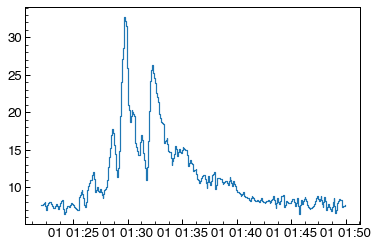

In [606]:
plt.plot(test_stix_2028.resample("4s").mean().interpolate(), drawstyle="steps-mid")

In [77]:
def read_and_plot_ospex_outputs():
    stix_file = "stx_spectrum_20211101_0040.fits"
    aa = fits.open(stix_file)
    count_rate = aa[1].data["RATE"]
    time = aa[1].data["TIME"]
    times = (Time(aa[1].header["MJDREF"] + aa[1].header["TIMEZERO"], format="mjd") + aa[1].data["TIME"]*u.s).datetime
    t_start = parse_time("2021-11-01 01:20")
    t_end = parse_time("2021-11-01 01:50")

    tindices = np.where((times>=t_start)&(times<=t_end))[0]
    c_rate_trun = count_rate[tindices, :]
    t_trun = times[tindices]
    e_low = aa[2].data["E_MIN"]
    e_high = aa[2].data["E_MAX"]

    e_indices = np.where((e_low>=10))[0]
    e_trun = e_low[e_indices]

    cmap = plt.cm.Spectral_r.copy()

    cmap.set_bad(cmap(0))
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.pcolormesh(t_trun, e_trun, c_rate_trun[:, e_indices].T, cmap=cmap, 
                   norm=colors.LogNorm(vmin=0.001, vmax=100))
    plt.yscale("log")
    plt.ylim(10, 100)
    plt.colorbar()

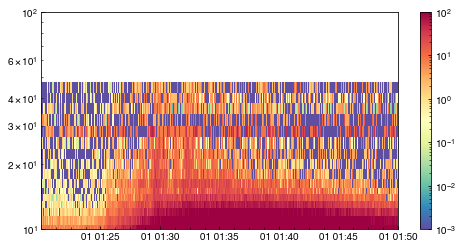

In [78]:
read_and_plot_ospex_outputs()

In [72]:
    stix_file = "stx_spectrum_20211101_0040.fits"
    aa = fits.open(stix_file)

In [28]:
for i in range(1, len(aa)):
    print(aa[i].data.dtype.names)

('RATE', 'STAT_ERR', 'CHANNEL', 'LIVETIME', 'SPEC_NUM', 'TIME', 'TIMEDEL')
('CHANNEL', 'E_MIN', 'E_MAX')
('SP_ATTEN_STATE$$TIME', 'SP_ATTEN_STATE$$STATE')
